### 地表覆盖/土地利用（LCLU）栅格数据分析（昆明）  
DEM数据来源：https://livingatlas.arcgis.com/landcoverexplorer


In [1]:
import numpy as np
import geopandas as gpd
import rasterio as rio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from rasterio.mask import mask


In [2]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  ## 设置中文字体
# plt.rcParams['axes.unicode_minus'] = False  ## 显示负号


#### 1. 数据读入

In [3]:
path_kunming_vec = 'data/data-section-6/kunming_5districts_utm48.gpkg'
path_lclu_2017 = 'data/data-section-6/48R_20170101-20180101_clip.tif'
path_lclu_2024 = 'data/data-section-6/48R_20240101-20241231_clip.tif'


In [4]:
kunming_gpd = gpd.read_file(path_kunming_vec)
kunming_gpd.head(3)


,dt_adcode,dt_name,ct_adcode,ct_name,pr_adcode,pr_name,cn_adcode,cn_name,area(km2),geometry
0,530102,五华区,530100,昆明市,530000,云南省,100000,中华人民共和国,388.681330,"MULTIPOLYGON (((269466.597 2782018.804, 269686..."
1,530103,盘龙区,530100,昆明市,530000,云南省,100000,中华人民共和国,864.295297,"MULTIPOLYGON (((269635.126 2771844.039, 269631..."
2,530111,官渡区,530100,昆明市,530000,云南省,100000,中华人民共和国,638.333617,"MULTIPOLYGON (((269663.017 2770589.114, 269738..."


<Axes: >

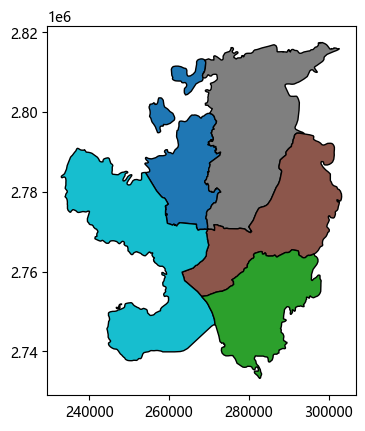

In [5]:
kunming_gpd.plot(column= 'dt_name', edgecolor='black', linewidth=1)


In [6]:
lclu_2017 = rio.open(path_lclu_2017)
lclu_2024 = rio.open(path_lclu_2024)

lclu_2017_bounds = lclu_2017.bounds
lclu_2024_bounds = lclu_2024.bounds
lclu_2017_arr = lclu_2017.read(1)
lclu_2024_arr = lclu_2024.read(1)


In [7]:
lclu_2017


<open DatasetReader name='data/data-section-6/48R_20170101-20180101_clip.tif' mode='r'>

In [8]:
# np.unique(lclu_2017_arr)
lclu_2017_arr = lclu_2017_arr.astype(float)
lclu_2024_arr = lclu_2024_arr.astype(float)
lclu_2017_arr[lclu_2017_arr == 0] = np.nan
lclu_2024_arr[lclu_2024_arr == 0] = np.nan


Text(0.5, 1.0, 'Land cover in 2024')

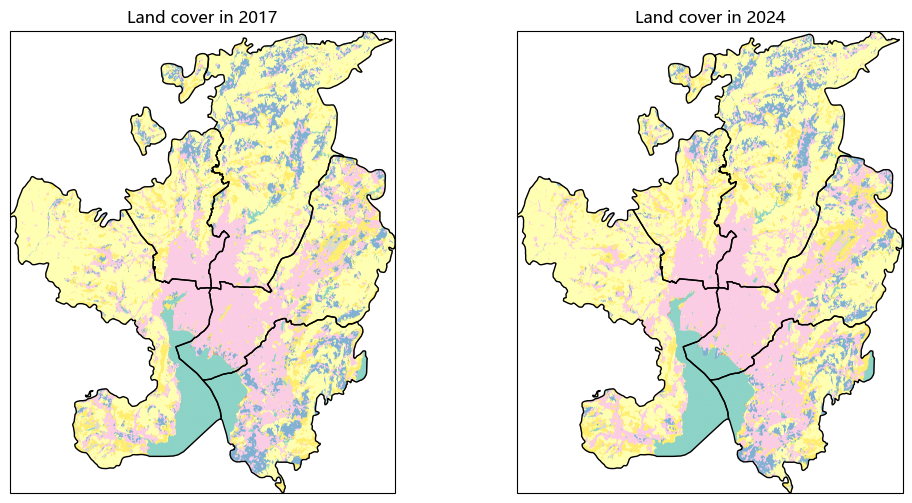

In [9]:
proj_utm48 = ccrs.UTM(zone=48, southern_hemisphere=False)
fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': proj_utm48})

## 2017
ax[0].imshow(lclu_2017_arr, cmap='Set3', vmin=1, vmax=11, 
                    extent=[lclu_2017_bounds.left, lclu_2017_bounds.right, 
                             lclu_2017_bounds.bottom, lclu_2017_bounds.top],
                    transform=proj_utm48)

kunming_gpd.plot(ax=ax[0], color='none', edgecolor='black', linewidth=1)   
ax[0].set_title('Land cover in 2017')   

## 2024
ax[1].imshow(lclu_2024_arr, cmap='Set3', vmin=1, vmax=11,
             extent=[lclu_2017_bounds.left, lclu_2017_bounds.right, 
                    lclu_2017_bounds.bottom, lclu_2017_bounds.top],
                    transform=proj_utm48)
kunming_gpd.plot(ax=ax[1], color='none', edgecolor='black', linewidth=1)   

ax[1].set_title('Land cover in 2024')


#### 2. 行政区面积分析

Text(0, 0.5, '面积(km2)')

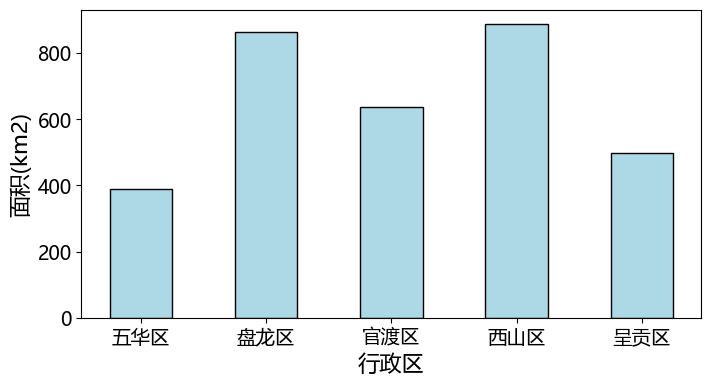

In [57]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(x = kunming_gpd['dt_name'], 
       height=kunming_gpd['area(km2)'], 
        facecolor='lightblue', 
        edgecolor='black',
        width=0.5) 
ax.tick_params(axis='both',
               labelsize=14)
ax.set_xlabel('行政区', fontsize=16)
ax.set_ylabel('面积(km2)', fontsize=16)


Text(0.5, 1.0, '昆明五区面积占比')

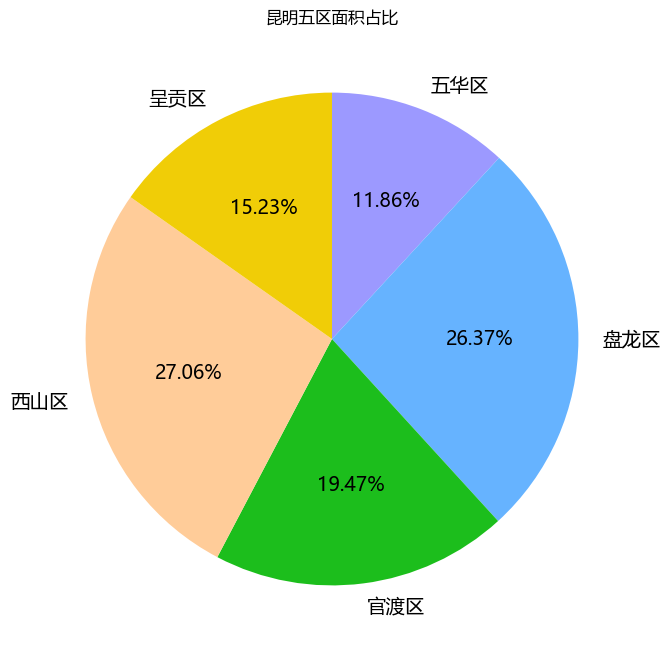

In [11]:
colors = ["#9C99FF", '#66B3FF', "#1CBE1C", '#FFCC99', "#F0CD07"]    
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(x = kunming_gpd['area(km2)'], 
        colors = colors,
        labels = kunming_gpd['dt_name'], 
        autopct = '%1.2f%%', 
        startangle = 90,        
        textprops={'fontsize':14},
        counterclock = False)

ax.set_title('昆明五区面积占比')



#### 3. 不同地类对比（2024年为例）    
像元值对应地类：1:水体，2：树木，4：淹没植被；5.农用地，7：建筑物，8：裸地，9：冰雪，10：云，11：牧场。


In [12]:
lclu_2017.meta


{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 7026,
 'height': 8423,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(10.0, 0.0, 233000.0,
        0.0, -10.0, 2817430.0)}

In [13]:
area_pixel = abs(lclu_2017.meta['transform'].a * lclu_2017.meta['transform'].e)/1000000
area_pixel


0.0001

In [14]:
num_pixel_wat = np.sum(lclu_2017_arr == 1)
num_pixel_tree = np.sum(lclu_2017_arr == 2)
num_pixel_flood_veg = np.sum(lclu_2017_arr == 4)
num_pixel_crops = np.sum(lclu_2017_arr == 5)
num_pixel_built = np.sum(lclu_2017_arr == 7)
num_pixel_bare = np.sum(lclu_2017_arr == 8)
num_pixel_snow = np.sum(lclu_2017_arr == 9)
num_pixel_cloud = np.sum(lclu_2017_arr == 10)
num_pixel_rangeland = np.sum(lclu_2017_arr == 11)
## area
area_wat = num_pixel_wat * area_pixel
area_tree = num_pixel_tree * area_pixel 
area_flood_veg = num_pixel_flood_veg * area_pixel
area_crops = num_pixel_crops * area_pixel
area_built = num_pixel_built * area_pixel
area_bare = num_pixel_bare * area_pixel
area_snow = num_pixel_snow * area_pixel
area_cloud = num_pixel_cloud * area_pixel
area_rangeland = num_pixel_rangeland * area_pixel
cla_area = {'water': area_wat,
            'tree': area_tree,
            'flood_veg': area_flood_veg,
            'crops': area_crops,
            'built': area_built,
            'bare': area_bare,
            'snow': area_snow,
            'cloud': area_cloud,
            'rangeland': area_rangeland}
cla_area


{'water': np.float64(245.4326),
 'tree': np.float64(1514.8829),
 'flood_veg': np.float64(1.5285),
 'crops': np.float64(316.3929),
 'built': np.float64(811.4203),
 'bare': np.float64(24.285800000000002),
 'snow': np.float64(0.0),
 'cloud': np.float64(0.4087),
 'rangeland': np.float64(363.4166)}

C:\Users\HP\AppData\Local\Temp\ipykernel_43716\1106646485.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['水体', '森林', '湿地', '农田', '建筑用地', '裸地', '雪盖', '云', '草地'],


Text(0, 0.5, '面积(km2)')

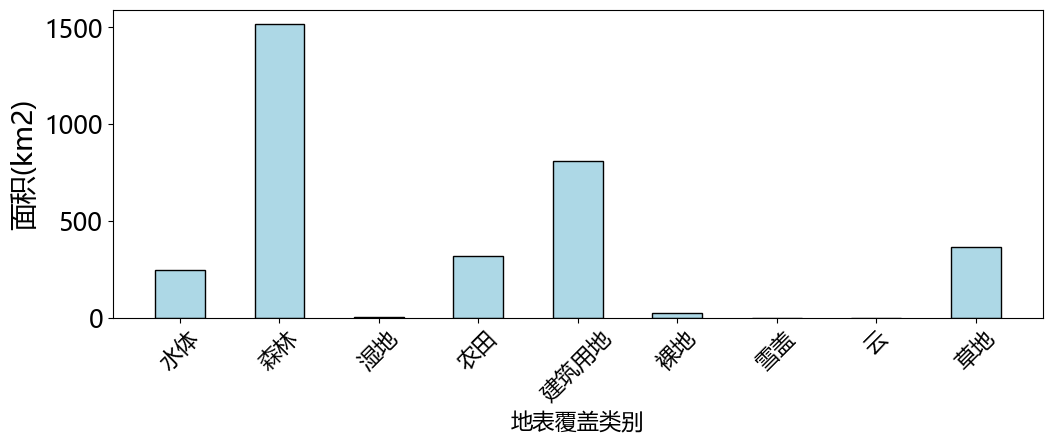

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(x=cla_area.keys(), 
        height=cla_area.values(), 
        facecolor='lightblue', 
        edgecolor='black',
        width=0.5) 
ax.tick_params(axis='both',
               labelsize=18)
ax.set_xticklabels(['水体', '森林', '湿地', '农田', '建筑用地', '裸地', '雪盖', '云', '草地'], 
                   rotation=45, fontsize=16)
ax.set_xlabel('地表覆盖类别', fontsize=16)
ax.set_ylabel('面积(km2)', fontsize=20)



#### 4. 不同区建筑物对比（2024年为例）   
  

In [16]:
kunming_gpd.head(3)


,dt_adcode,dt_name,ct_adcode,ct_name,pr_adcode,pr_name,cn_adcode,cn_name,area(km2),geometry
0,530102,五华区,530100,昆明市,530000,云南省,100000,中华人民共和国,388.681330,"MULTIPOLYGON (((269466.597 2782018.804, 269686..."
1,530103,盘龙区,530100,昆明市,530000,云南省,100000,中华人民共和国,864.295297,"MULTIPOLYGON (((269635.126 2771844.039, 269631..."
2,530111,官渡区,530100,昆明市,530000,云南省,100000,中华人民共和国,638.333617,"MULTIPOLYGON (((269663.017 2770589.114, 269738..."


In [17]:
## 数据准备
### 各区矢量几何数据    
wuhua_gpd = kunming_gpd[kunming_gpd['dt_name'] == '五华区']
wuhua_gpd.geometry
### 地表覆盖栅格数据     
lclu_2024


<open DatasetReader name='data/data-section-6/48R_20240101-20241231_clip.tif' mode='r'>

In [18]:
list(wuhua_gpd.geometry)


[<MULTIPOLYGON (((269466.597 2782018.804, 269686.504 2782095.752, 269933.183 ...>]

In [19]:
#### 矢量裁剪

# 使用mask函数裁剪栅格
lclu_2017_clip_data, lclu_2017_clip_transform = mask(    
    dataset=lclu_2017,
    shapes=list(wuhua_gpd.geometry),  # 使用GeoDataFrame的geometry列
    crop=True,              # 将栅格裁剪到矢量边界
    all_touched=False,      # 仅裁剪中心点在矢量内的像元
    nodata=lclu_2017.nodata       # 无效值设为原始栅格的nodata
)


In [20]:
num_pixel_built = np.sum(lclu_2017_clip_data == 7)
area_build_wuhua = num_pixel_built * area_pixel
area_build_wuhua


np.float64(104.4042)

In [21]:
def get_area_by_district(lclu_src, geo, area_pixel, dn_class):
    lclu_clip_data, lclu_clip_transform = mask(    
    dataset=lclu_src,
    shapes=list(geo),           # 使用GeoDataFrame的geometry列
    crop=True,                  # 将栅格裁剪到矢量边界
    all_touched=False,          # 仅裁剪中心点在矢量内的像元
    nodata=lclu_2017.nodata     # 无效值设为原始栅格的nodata
    )
    num_pixel_cla = np.sum(lclu_clip_data == dn_class)
    area_cla = num_pixel_cla * area_pixel
    return area_cla


In [22]:
list(wuhua_gpd['geometry'])


[<MULTIPOLYGON (((269466.597 2782018.804, 269686.504 2782095.752, 269933.183 ...>]

In [23]:
panlong_gpd = kunming_gpd.loc[kunming_gpd['dt_name'] == '盘龙区']
guandu_gpd = kunming_gpd.loc[kunming_gpd['dt_name'] == '官渡区']
xishan_gpd = kunming_gpd.loc[kunming_gpd['dt_name'] == '西山区']
chenggong_gpd = kunming_gpd.loc[kunming_gpd['dt_name'] == '呈贡区']

area_built_panlong = get_area_by_district(lclu_2017, panlong_gpd['geometry'], area_pixel, 7)
area_built_guandu = get_area_by_district(lclu_2017, guandu_gpd['geometry'], area_pixel, 7)
area_built_xishan = get_area_by_district(lclu_2017, xishan_gpd['geometry'], area_pixel, 7)  
area_built_chenggong = get_area_by_district(lclu_2017, chenggong_gpd['geometry'], area_pixel, 7)


In [24]:
area_built_district = {
    '五华区': area_build_wuhua,
    '盘龙区': area_built_panlong,
    '官渡区': area_built_guandu,
    '西山区': area_built_xishan,
    '呈贡区': area_built_chenggong 
}
area_built_district


{'五华区': np.float64(104.4042),
 '盘龙区': np.float64(134.4092),
 '官渡区': np.float64(254.4152),
 '西山区': np.float64(167.9984),
 '呈贡区': np.float64(150.1933)}

Text(0, 0.5, '建筑物面积(km2)')

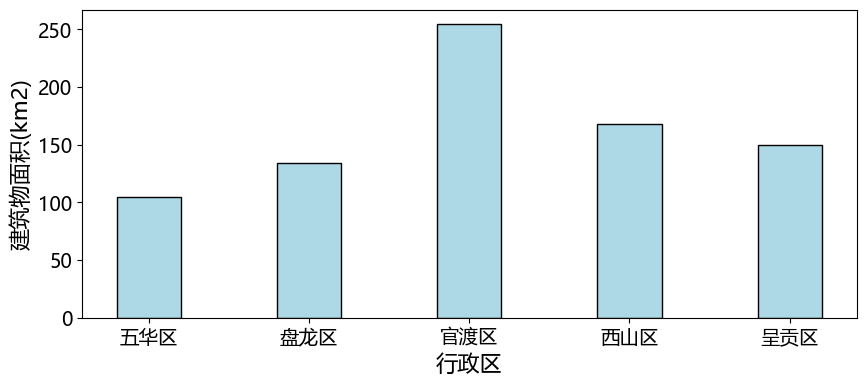

In [ ]:
## 建筑物面积对比
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x=area_built_district.keys(), 
        height=area_built_district.values(), 
        facecolor='lightblue', 
        edgecolor='black',
        width=0.4) 
ax.tick_params(axis='both',
               labelsize=14)
ax.set_xlabel('行政区', fontsize=16)
ax.set_ylabel('建筑物面积(km2)', fontsize=16)



Text(0, 0.5, '建筑物面积(km2)')

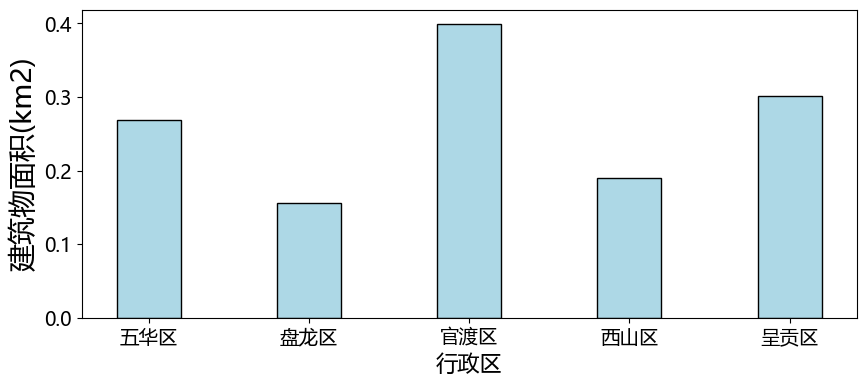

In [58]:
### 建筑物占总面积对比
ratio_built = np.array(list(area_built_district.values()))/kunming_gpd['area(km2)']
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x=area_built_district.keys(), 
        height=ratio_built, 
        facecolor='lightblue', 
        edgecolor='black', 
        width=0.4) 
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('行政区', fontsize=16)
ax.set_ylabel('建筑物面积(km2)', fontsize=20)


#### 5. 昆明市地表覆盖变化分析（以建筑物为例）

In [ ]:
np.unique(lclu_2017_arr)


array([ 1.,  2.,  4.,  5.,  7.,  8., 10., 11., nan])

In [30]:
### 去除建筑物以外类别
lclu_2017_built_arr = np.where(lclu_2017_arr == 7, 1, 0)
lclu_2024_built_arr = np.where(lclu_2024_arr == 7, 1, 0)
lclu_2017_built_arr = np.where(np.isnan(lclu_2017_arr), np.nan, lclu_2017_built_arr)
lclu_2024_built_arr = np.where(np.isnan(lclu_2024_arr), np.nan, lclu_2024_built_arr)
np.unique(lclu_2017_built_arr)


array([ 0.,  1., nan])

Text(0.5, 1.0, 'Land cover in 2024')

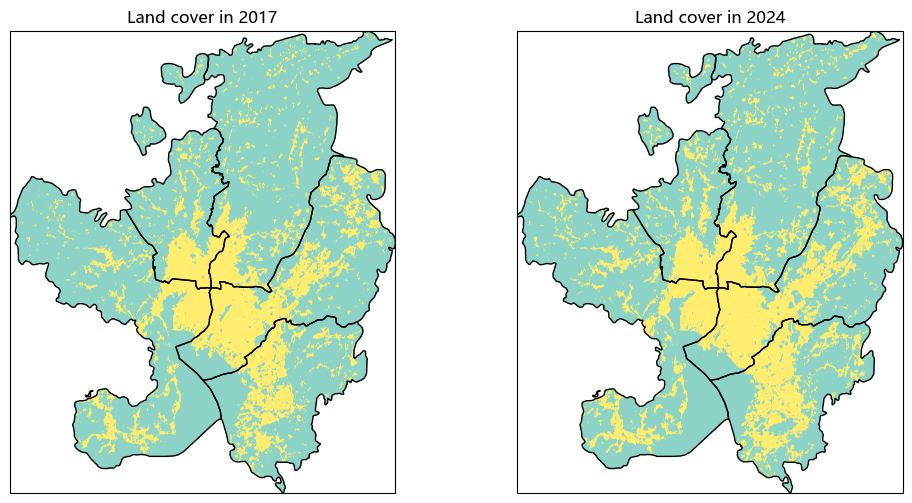

In [31]:
proj_utm48 = ccrs.UTM(zone=48, southern_hemisphere=False)
fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': proj_utm48})

## 2017
ax[0].imshow(lclu_2017_built_arr, cmap='Set3', vmin=0, vmax=1, 
                    extent=[lclu_2017_bounds.left, lclu_2017_bounds.right, 
                             lclu_2017_bounds.bottom, lclu_2017_bounds.top],
                    transform=proj_utm48)

kunming_gpd.plot(ax=ax[0], color='none', edgecolor='black', linewidth=1)   
ax[0].set_title('Land cover in 2017')   

## 2024
ax[1].imshow(lclu_2024_built_arr, cmap='Set3', vmin=0, vmax=1,
             extent=[lclu_2024_bounds.left, lclu_2024_bounds.right, 
                    lclu_2024_bounds.bottom, lclu_2024_bounds.top],
                    transform=proj_utm48)
kunming_gpd.plot(ax=ax[1], color='none', edgecolor='black', linewidth=1)   

ax[1].set_title('Land cover in 2024')


In [32]:
## 2017年地表覆盖数据准备
num_pixel_built_2017 = np.sum(lclu_2017_built_arr == 1)
area_built_2017 = num_pixel_built_2017 * area_pixel
num_pixel_built_2024 = np.sum(lclu_2024_built_arr == 1)
area_built_2024 = num_pixel_built_2024 * area_pixel


In [33]:
area_built_timeseries = {
    '2017': area_built_2017,
    '2024': area_built_2024
}
area_built_timeseries

{'2017': np.float64(811.4203), '2024': np.float64(940.6934)}

Text(0, 0.5, '面积(km2)')

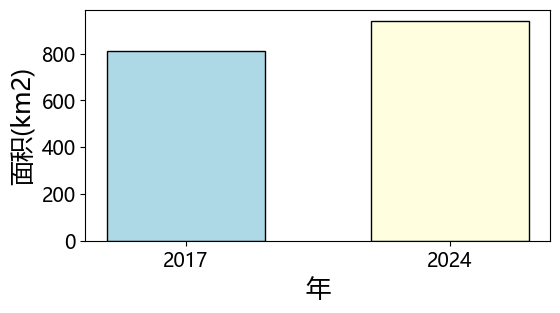

In [59]:
### 根据此例可分析不同行政区建筑物面积变化
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(x=area_built_timeseries.keys(), 
        height=area_built_timeseries.values(), 
        facecolor=['lightblue', 'lightyellow'], 
        edgecolor='black',
        width=0.6)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('年', fontsize=18)
ax.set_ylabel('面积(km2)', fontsize=18)


#### 6. 建筑物变化空间特征分析（以昆明为例）  
建筑物在哪些位置发生变化？   
思路： 对建筑物变化像元进行赋值，如增加的建筑物像元赋值1， 减少的建筑物像元赋值-1， 不变的赋值0，然后对结果进行可视化呈现。    
如何对变化信息进行赋值：矩阵运算，将2017年栅格数据中建筑物赋值0，非建筑物赋值1。2024年栅格数据中建筑物赋值0，非建筑物赋值2。将2024年栅格减去2017年栅格。    
|       |2017|2024| 
| ----  |----|----|   
|建筑物  | 1  | 1  |
|非建筑物| 0  | 0  | 

In [35]:
## 检查两幅影像尺寸、分辨率、空间范围是否一致。如不一致，需进行重采样统一。
from pprint import pprint
pprint(lclu_2017.meta)
pprint(lclu_2024.meta) 


{'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 8423,
 'nodata': None,
 'transform': Affine(10.0, 0.0, 233000.0,
       0.0, -10.0, 2817430.0),
 'width': 7026}
{'count': 1,
 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 48N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",105],PA

In [36]:
dif_built_arr = lclu_2024_built_arr - lclu_2017_built_arr
np.unique(dif_built_arr)


array([-1.,  0.,  1., nan])

In [37]:
lclu_2017.meta['dtype']


'uint8'

In [38]:
path_built_change = 'data/data-section-6/built_change.tif'
# with rio.open(fp=path_built_change, 
#                 mode='w',
#                 driver=lclu_2017.meta['driver'],
#                 height=lclu_2017.meta['height'],
#                 width=lclu_2017.meta['width'],
#                 count=1,
#                 dtype=np.float32(),   ## 采用浮点型
#                 crs=lclu_2017.meta['crs'],
#                 transform=lclu_2017.meta['transform'],
#                 nodata=lclu_2017.meta['nodata'],
#               ) as built_change_src:
#     built_change_src.write(dif_built_arr, 1)



In [39]:
built_change_src = rio.open(path_built_change)
built_change_src_arr = built_change_src.read(1)


In [40]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# 分类数据（DN值对应类别）
classes = np.array([-1, 0, 1, 2])   # DN值区间：[-1, 0), [0, 1), [1, 2)]

# 定义颜色和边界
colors = ["#00FFFF", "#C0C0C0", "#FF00FF"]   # 
cmap = ListedColormap(colors)
norm = BoundaryNorm(classes, cmap.N)


Text(0.5, 1.0, 'Land cover changes')

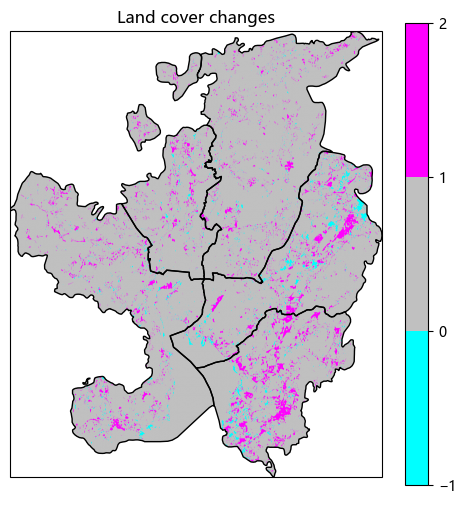

In [41]:
proj_utm48 = ccrs.UTM(zone=48, southern_hemisphere=False)
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': proj_utm48})

## 2017
img = ax.imshow(built_change_src_arr, cmap=cmap, norm=norm, 
                    extent=[built_change_src.bounds.left, built_change_src.bounds.right, 
                             built_change_src.bounds.bottom, built_change_src.bounds.top],
                    transform=proj_utm48)

kunming_gpd.plot(ax=ax, color='none', edgecolor='black', linewidth=1)   
plt.colorbar(img)
ax.set_title('Land cover changes')   


In [42]:
### 统计并比较不同行政区域建筑物面积变化
### 该函数与获取各区建筑物面积函数相同
def get_area_by_district(built_change_src, geo, area_pixel, dn_class):
    built_clip_data, built_clip_transform = mask(    
    dataset=built_change_src,
    shapes=list(geo),           # 使用GeoDataFrame的geometry列
    crop=True,                  # 将栅格裁剪到矢量边界
    all_touched=False,          # 仅裁剪中心点在矢量内的像元
    nodata=lclu_2017.nodata     # 无效值设为原始栅格的nodata
    )
    num_pixel_cla = np.sum(built_clip_data == dn_class)
    area_cla = num_pixel_cla * area_pixel
    return area_cla


In [44]:
built_increase_wuhua = get_area_by_district(built_change_src, wuhua_gpd['geometry'], area_pixel, 1)
built_decrease_wuhua = get_area_by_district(built_change_src, wuhua_gpd['geometry'], area_pixel, -1)
built_increase_panlong = get_area_by_district(built_change_src, panlong_gpd['geometry'], area_pixel, 1)
built_decrease_panlong = get_area_by_district(built_change_src, panlong_gpd['geometry'], area_pixel, -1)
built_increase_guandu = get_area_by_district(built_change_src, guandu_gpd['geometry'], area_pixel, 1)
built_decrease_guandu = get_area_by_district(built_change_src, guandu_gpd['geometry'], area_pixel, -1)
built_increase_xishan = get_area_by_district(built_change_src, xishan_gpd['geometry'], area_pixel, 1)
built_decrease_xishan = get_area_by_district(built_change_src, xishan_gpd['geometry'], area_pixel, -1)
built_increase_chenggong = get_area_by_district(built_change_src, chenggong_gpd['geometry'], area_pixel, 1)
built_decrease_chenggong = get_area_by_district(built_change_src, chenggong_gpd['geometry'], area_pixel, -1)


In [45]:
built_increase_district = {
    '五华区': built_increase_wuhua,
    '盘龙区': built_increase_panlong,
    '官渡区': built_increase_guandu,
    '西山区': built_increase_xishan,
    '呈贡区': built_increase_chenggong 
}

built_decrease_district = {
    '五华区': built_decrease_wuhua,
    '盘龙区': built_decrease_panlong,
    '官渡区': built_decrease_guandu,
    '西山区': built_decrease_xishan,
    '呈贡区': built_decrease_chenggong 
}
built_decrease_district

{'五华区': np.float64(4.1516),
 '盘龙区': np.float64(6.3303),
 '官渡区': np.float64(22.377100000000002),
 '西山区': np.float64(10.3032),
 '呈贡区': np.float64(11.2857)}

In [50]:
built_decrease_district.keys()


dict_keys(['五华区', '盘龙区', '官渡区', '西山区', '呈贡区'])

In [ ]:
# 设置条形图的偏移量，使不同类别的条形错开显示
bar_width = 0.25
x = np.arange(len(built_increase_district))

ax.clear()
ax.bar(x - bar_width, list(built_increase_district.values()), 
        width=bar_width, label='增加', color='lightblue', edgecolor='black')
ax.bar(x, -np.array(list(built_decrease_district.values())), 
        width=bar_width, label='减少', color='lightyellow', edgecolor='black')
ax.bar(x + bar_width, 
        np.array(list(built_increase_district.values())) - np.array(list(built_decrease_district.values())), 
        width=bar_width, label='净增加', color='green', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(list(built_increase_district.keys()), fontsize=14)
ax.legend(fontsize=14)


Text(0, 0.5, '增加建筑物面积(km2)')

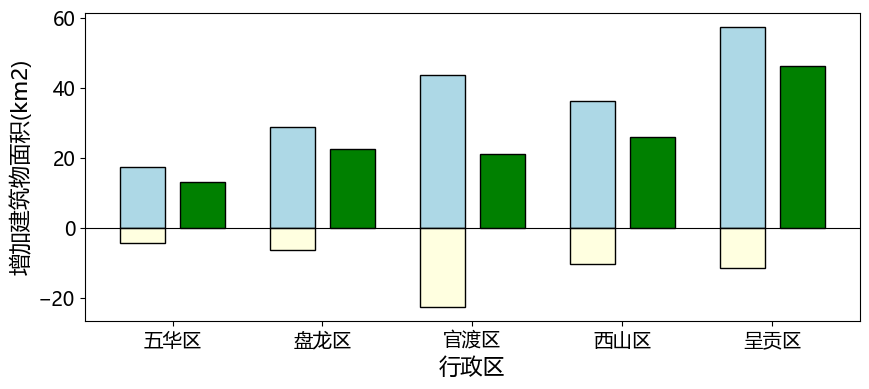

In [ ]:
### 不同行政区建筑物面积变化对比
fig, ax = plt.subplots(figsize=(10, 4))
x_num = np.arange(len(built_increase_district))
ax.bar(
        # x = built_increase_district.keys(), 
        x = x_num,
        height= built_increase_district.values(),
        facecolor='lightblue', 
        label='增加',
        edgecolor='black', 
        width=0.3) 

ax.bar(
        # x = built_decrease_district.keys(), 
        x = x_num,
        height=np.array(list(built_decrease_district.values()))*-1,
        facecolor='lightyellow', 
        edgecolor='black', 
        label='减少',
        width=0.3) 

ax.bar(
        # x=built_decrease_district.keys(), 
        x = x_num+0.4,
        height=np.array(list(built_increase_district.values()))-np.array(list(built_decrease_district.values())),
        facecolor='green', 
        edgecolor='black', 
        label='净增加',        
        width=0.3) 

ax.axhline(0, color='black', linewidth=0.8)
ax.set_xticks(ticks=x_num+0.2, labels=list(built_increase_district.keys()))
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('行政区', fontsize=16)
ax.set_ylabel('增加建筑物面积(km2)', fontsize=16)
